### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.layers import Input, Dense
from training.datasets import load_dataset
from models.gpu.layers import IsotopeNormalizer, ConcentrationRatios
from models.gpu.metrics import MaxAbsoluteError
from training.utils import CustomTensorboard
from models.analytical import MultiOccupationMultiIsotope
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from keras import ops

# Multi-Occupation, Multi Isotope, fixed matrix, normalized

initial values: [4.57020506e-02 1.95302553e-04 2.15528637e-02 6.33705119e-02
 4.26330016e-05 6.56533739e-02 1.03788127e-02 2.98493504e-02
 4.32893774e-02 5.77945278e-02 5.32343730e-02 7.19905312e-02]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


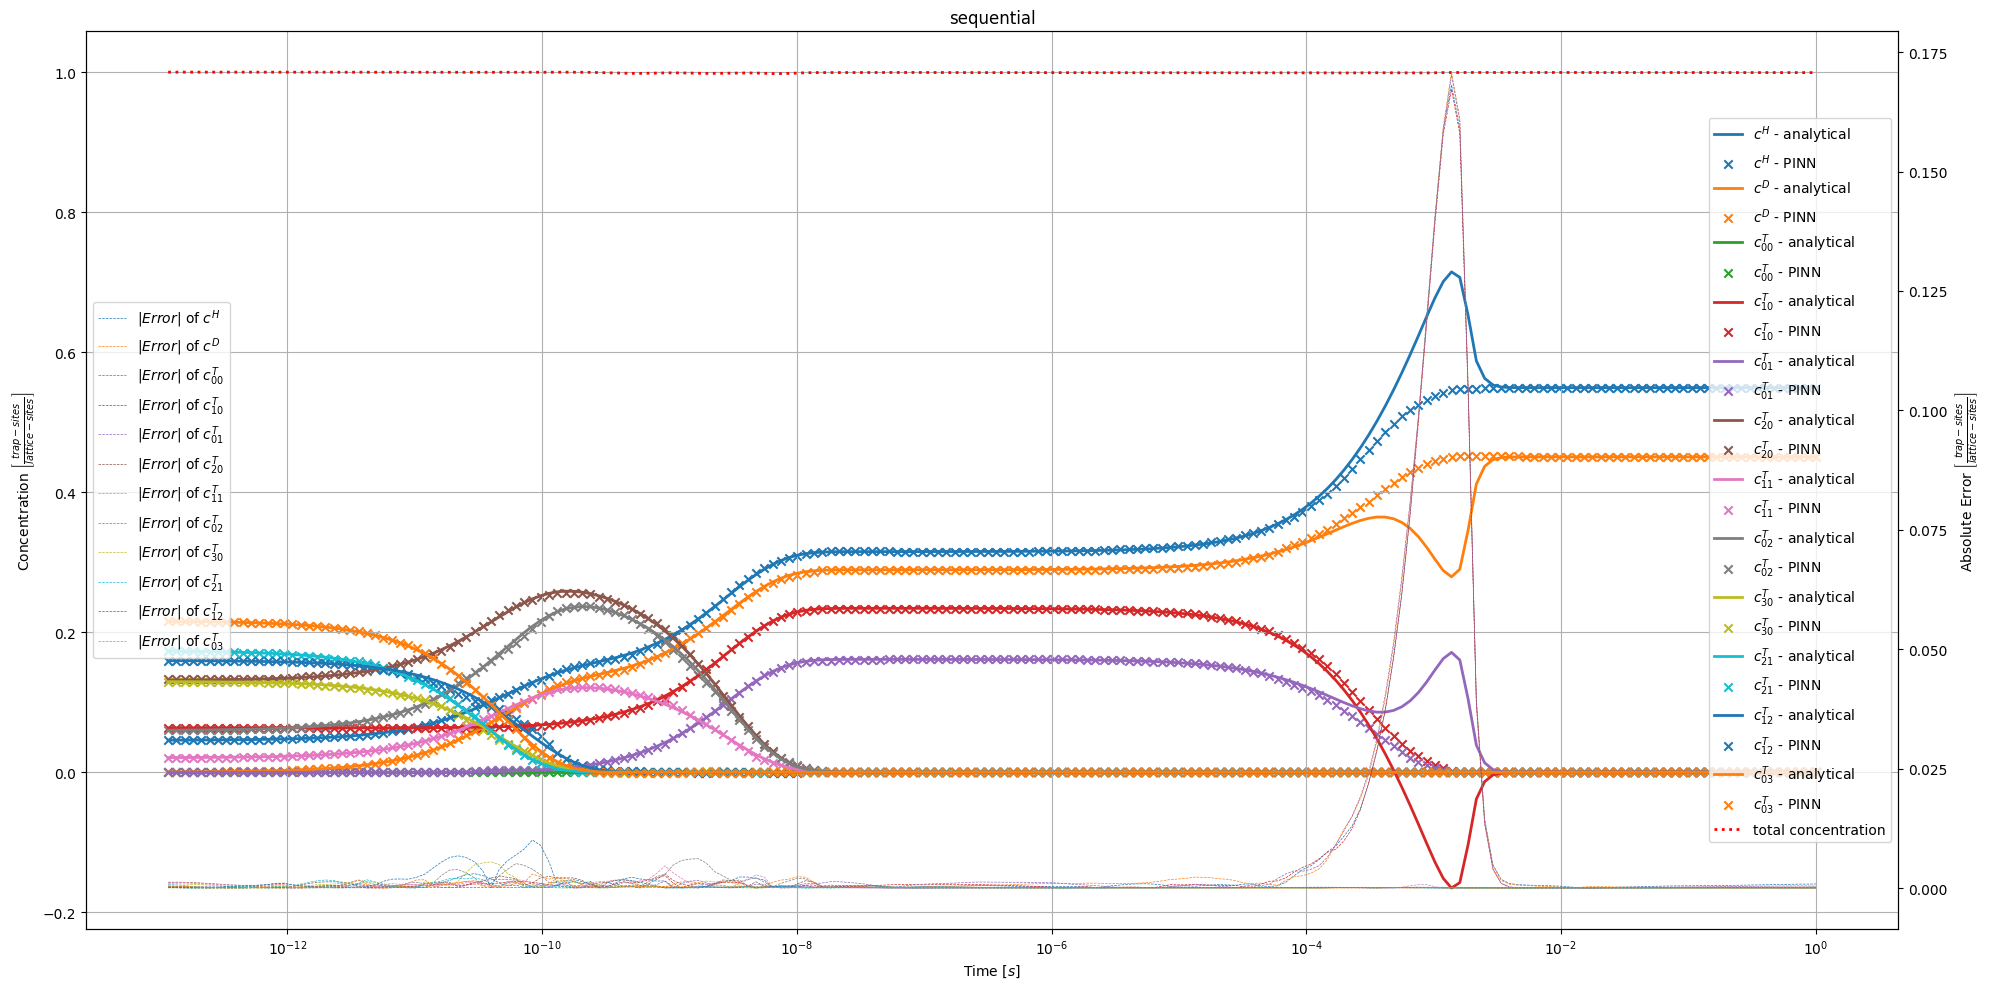

In [43]:
initial_values = worst_iv  # val_x[worst[-1],1:]

print(f"initial values: {initial_values}")
momi.evaluate(
    model,
    pre_normalized=True,
    initial_values=initial_values,
    n_eval=200,
    log_t_eval=True,
)

# Multi-Occupation, Multi Isotope, random matrix, normalized

In [3]:
info, (train_x, train_y), (val_x, val_y) = load_dataset(
    "Multi-Occupation, Multi Isotope, random matrix, normalized"
)

In [4]:
model = keras.models.load_model("final_models/full_model.keras")
model = keras.Sequential([model, keras.layers.Lambda(lambda x: x["normed"])])

In [5]:
predictions = model.predict(val_x, batch_size=2**16)
delta = ops.max(ops.abs(ops.array(predictions) - ops.array(val_y)), axis=1)
indices = ops.argsort(delta)
delta_cpu = delta.cpu().numpy()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [7]:
np.median(delta_cpu)

np.float32(0.00071967766)

In [11]:
good = np.sum(delta_cpu <= 0.01)
bad = np.sum(delta_cpu > 0.01)
total = bad + good
good /= total
bad /= total

In [8]:
from saveable import saveable

In [9]:
plt.style.use("latex.mplstyle")

Saved figure to report/figures/error_distribution.pdf


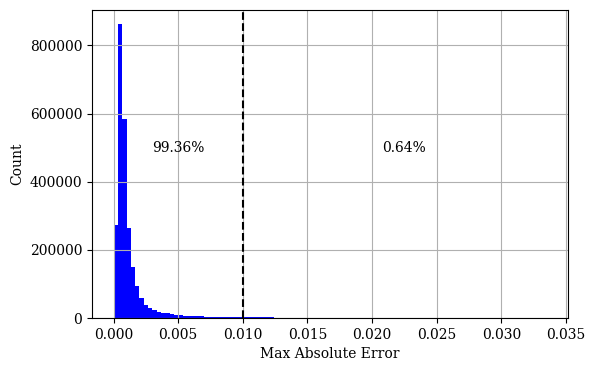

In [21]:
@saveable()
def plot_deltas(deltas):
    _ = plt.hist(deltas, bins=100, color="blue")
    plt.grid()
    ylim = plt.gca().get_ylim()
    plt.vlines([0.01], [ylim[0]], [ylim[1]], colors=["black"], linestyles="--")
    plt.text(0.005, 500000, f"{good:.2%}", ha="center", va="center")
    plt.text(0.0225, 500000, f"{bad:.2%}", ha="center", va="center")
    plt.ylim(ylim)
    plt.xlabel("Max Absolute Error")
    plt.ylabel("Count")
    # plt.xscale("log")


plot_deltas(delta_cpu, save=True, savename="error_distribution")

In [13]:
worst = indices[-100:]
# index = 1433095
# index = 391828
# index = 19924299
# index = 111247
# index = 996095
# index = 234685
index = worst[-1]
# index = 35429799
# index = 23824478
# index = 10

In [14]:
from models.analytical import TrapDiffusion, MultiOccupationMultiIsotope
from saveable import saveable

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Saved figure to report/figures/usual_error.pdf
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Saved figure to report/figures/largest_error.pdf


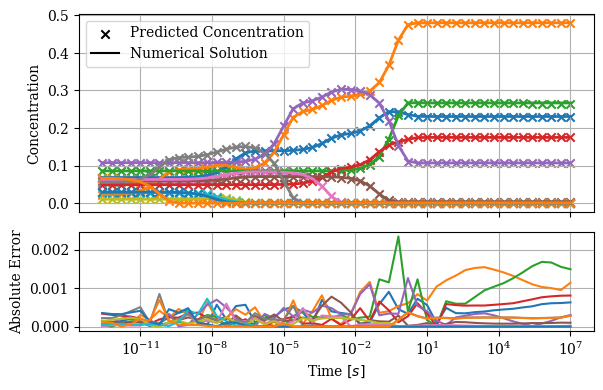

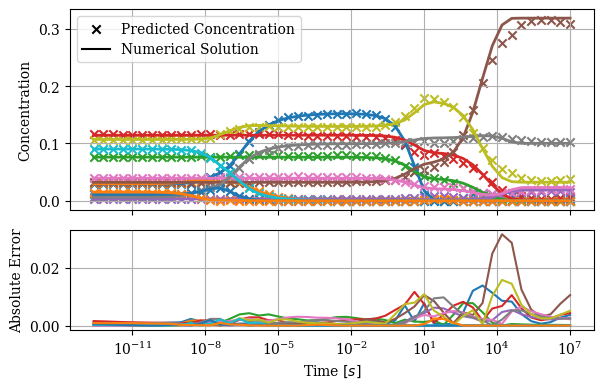

In [41]:
# index = np.random.randint(0, len(val_x))
# index = np.random.choice(indices.cpu().numpy()[-100:])

# print(index)
# worst_iv = val_x[index, 1:]
# momi_random = MultiOccupationMultiIsotope(normalized_rs=worst_iv[-9:])
# initial_values = worst_iv
# print(index)


@saveable()
def eval2(index, model, **kwargs):
    # index = 123
    worst_iv = val_x[index, 1:]
    momi_random = MultiOccupationMultiIsotope(normalized_rs=worst_iv[-9:])
    initial_values = worst_iv
    momi_random.evaluate(
        model,
        include_params=True,
        initial_values=initial_values[:-9],
        n_eval=50,
        log_t_eval=True,
        legend=False,
        **kwargs
        # save=True,
        # savename="largest_error",
    )


eval2(0, model, save=True, savename="usual_error")
eval2(2011785, model, save=True, savename="largest_error")

In [54]:
model = keras.models.load_model("final_models/full_model.keras")
model = keras.Sequential([model, keras.layers.Lambda(lambda x: x["normed"])])
no_norm_model = keras.models.load_model("final_models/full_model_no_norm.keras")
no_norm_model = keras.Sequential(
    [no_norm_model, keras.layers.Lambda(lambda x: x["unnormed"])]
)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Saved figure to report/figures/normed_mass.pdf
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Saved figure to report/figures/unnormed_mass.pdf


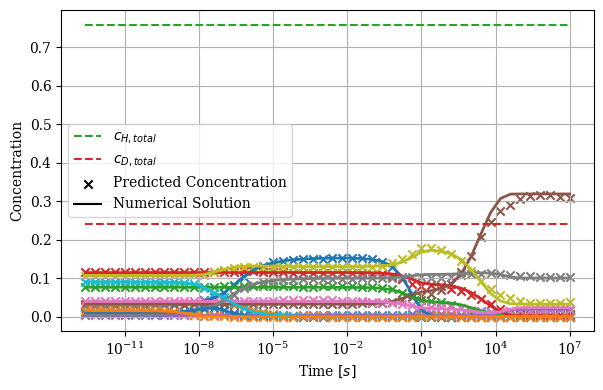

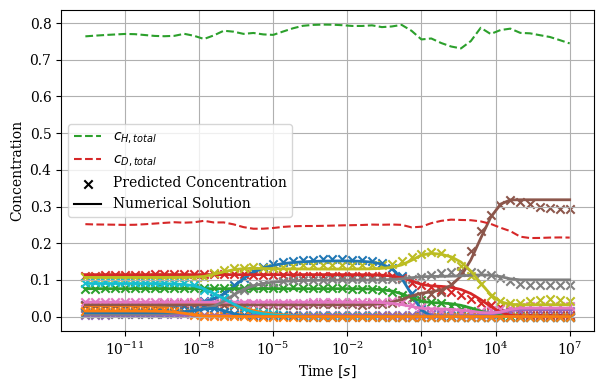

In [58]:
eval2(2011785, model, plot_masses=True, plot_error=False, savename="normed_mass.pdf")
eval2(
    2011785,
    no_norm_model,
    plot_masses=True,
    plot_error=False,
    savename="unnormed_mass.pdf",
)

In [6]:
from models.analytical import MultiOccupationMultiIsotope
import numpy as np

momi = MultiOccupationMultiIsotope(
    normalized_rs=np.array(
        [
            0.25362267,
            0.25384203,
            0.30700604,
            0.4207966,
            0.43292755,
            0.45427036,
            0.48187402,
            0.5092227,
            0.57197576,
        ]
    )
)
momi.plot(
    n_eval=50,
    initial_values=np.array(
        [
            0.01804437,
            0.05964848,
            0.00549688,
            0.0236339,
            0.00259349,
            0.00015296,
            0.03060301,
            0.03449444,
            0.0144678,
            0.05395289,
            0.09995401,
            0.08681828,
        ]
    ),
    faulty=True,
)

AssertionError: Expected 50 evaluations, got 48
y0=array([0.01804437, 0.05964848, 0.00549688, 0.0236339 , 0.00259349,
       0.00015296, 0.03060301, 0.03449444, 0.0144678 , 0.05395289,
       0.09995401, 0.08681828])
t_eval=array([2.51188643e-13, 6.30957344e-13, 1.58489319e-12, 3.98107171e-12,
       1.00000000e-11, 2.51188643e-11, 6.30957344e-11, 1.58489319e-10,
       3.98107171e-10, 1.00000000e-09, 2.51188643e-09, 6.30957344e-09,
       1.58489319e-08, 3.98107171e-08, 1.00000000e-07, 2.51188643e-07,
       6.30957344e-07, 1.58489319e-06, 3.98107171e-06, 1.00000000e-05,
       2.51188643e-05, 6.30957344e-05, 1.58489319e-04, 3.98107171e-04,
       1.00000000e-03, 2.51188643e-03, 6.30957344e-03, 1.58489319e-02,
       3.98107171e-02, 1.00000000e-01, 2.51188643e-01, 6.30957344e-01,
       1.58489319e+00, 3.98107171e+00, 1.00000000e+01, 2.51188643e+01,
       6.30957344e+01, 1.58489319e+02, 3.98107171e+02, 1.00000000e+03,
       2.51188643e+03, 6.30957344e+03, 1.58489319e+04, 3.98107171e+04,
       1.00000000e+05, 2.51188643e+05, 6.30957344e+05, 1.58489319e+06,
       3.98107171e+06, 1.00000000e+07])
sol.t=array([2.51188643e-13, 6.30957344e-13, 1.58489319e-12, 3.98107171e-12,
       1.00000000e-11, 2.51188643e-11, 6.30957344e-11, 1.58489319e-10,
       3.98107171e-10, 1.00000000e-09, 2.51188643e-09, 6.30957344e-09,
       1.58489319e-08, 3.98107171e-08, 1.00000000e-07, 2.51188643e-07,
       6.30957344e-07, 1.58489319e-06, 3.98107171e-06, 1.00000000e-05,
       2.51188643e-05, 6.30957344e-05, 1.58489319e-04, 3.98107171e-04,
       1.00000000e-03, 2.51188643e-03, 6.30957344e-03, 1.58489319e-02,
       3.98107171e-02, 1.00000000e-01, 2.51188643e-01, 6.30957344e-01,
       1.58489319e+00, 3.98107171e+00, 1.00000000e+01, 2.51188643e+01,
       6.30957344e+01, 1.58489319e+02, 3.98107171e+02, 1.00000000e+03,
       2.51188643e+03, 6.30957344e+03, 1.58489319e+04, 3.98107171e+04,
       1.00000000e+05, 2.51188643e+05, 6.30957344e+05, 1.58489319e+06])
sol.y=array([[ 1.80447408e-02,  1.80453015e-02,  1.80467099e-02,
         1.80502475e-02,  1.80591335e-02,  1.80814111e-02,
         1.81359830e-02,  1.82721539e-02,  1.86039698e-02,
         1.93710970e-02,  2.09195856e-02,  2.31550710e-02,
         2.45965109e-02,  2.44220487e-02,  2.40967949e-02,
         2.40443866e-02,  2.40445965e-02,  2.40461614e-02,
         2.40500141e-02,  2.40596913e-02,  2.40839968e-02,
         2.41449394e-02,  2.42979910e-02,  2.46816643e-02,
         2.56408378e-02,  2.80193672e-02,  3.38044801e-02,
         4.71817382e-02,  7.47134300e-02,  1.18638924e-01,
         1.61083326e-01,  1.78288457e-01,  1.77614693e-01,
         1.74108402e-01,  1.71033958e-01,  1.70194243e-01,
         1.70180083e-01,  1.70180325e-01,  1.70180311e-01,
         1.70180305e-01,  1.70180362e-01,  1.70179832e-01,
         1.70179027e-01,  1.70179765e-01,  1.70179683e-01,
         1.70177064e-01,  1.70182140e-01,  1.70170811e-01],
       [ 5.96481092e-02,  5.96475485e-02,  5.96461401e-02,
         5.96426025e-02,  5.96337165e-02,  5.96114390e-02,
         5.95568672e-02,  5.94206967e-02,  5.90888817e-02,
         5.83217568e-02,  5.67732739e-02,  5.45378033e-02,
         5.30964024e-02,  5.32709683e-02,  5.35964963e-02,
         5.36496062e-02,  5.36511610e-02,  5.36540287e-02,
         5.36613085e-02,  5.36795901e-02,  5.37254987e-02,
         5.38404427e-02,  5.41290131e-02,  5.48493518e-02,
         5.66325452e-02,  6.09490208e-02,  7.08212004e-02,
         9.03812715e-02,  1.17724328e-01,  1.32650624e-01,
         1.24661080e-01,  1.16540368e-01,  1.13462104e-01,
         1.07819504e-01,  1.00164392e-01,  9.73601153e-02,
         9.72865630e-02,  9.72872868e-02,  9.72872612e-02,
         9.72872610e-02,  9.72873139e-02,  9.72867973e-02,
         9.72860119e-02,  9.72867286e-02,  9.72866495e-02,
         9.72841040e-02,  9.72890370e-02,  9.72780281e-02],
       [ 5.49688000e-03,  5.49688000e-03,  5.49688000e-03,
         5.49688000e-03,  5.49688000e-03,  5.49688000e-03,
         5.49688000e-03,  5.49688000e-03,  5.49688000e-03,
         5.49688000e-03,  5.49688000e-03,  5.49688000e-03,
         5.49687999e-03,  5.49687998e-03,  5.49687996e-03,
         5.49687989e-03,  5.49687973e-03,  5.49687932e-03,
         5.49687830e-03,  5.49687573e-03,  5.49686926e-03,
         5.49685293e-03,  5.49681186e-03,  5.49670767e-03,
         5.49643987e-03,  5.49572874e-03,  5.49371023e-03,
         5.48733597e-03,  5.46533563e-03,  5.39102444e-03,
         5.17259892e-03,  4.62865184e-03,  3.49913027e-03,
         1.76286048e-03,  3.35674844e-04,  5.65909677e-06,
        -5.24099394e-08,  1.98217059e-08,  1.49696195e-08,
         1.31482760e-08,  1.40008784e-08,  1.44999345e-08,
         1.54208879e-08,  1.54202498e-08,  1.54202705e-08,
         1.54209436e-08,  1.54196394e-08,  1.54225508e-08],
       [ 2.36339000e-02,  2.36339000e-02,  2.36339000e-02,
         2.36339000e-02,  2.36339000e-02,  2.36339000e-02,
         2.36339000e-02,  2.36339000e-02,  2.36339000e-02,
         2.36339000e-02,  2.36339000e-02,  2.36339000e-02,
         2.36339000e-02,  2.36338999e-02,  2.36338998e-02,
         2.36338996e-02,  2.36338990e-02,  2.36338976e-02,
         2.36338939e-02,  2.36338847e-02,  2.36338616e-02,
         2.36338031e-02,  2.36336562e-02,  2.36332828e-02,
         2.36323212e-02,  2.36297547e-02,  2.36223983e-02,
         2.35988428e-02,  2.35167575e-02,  2.32408000e-02,
         2.24422606e-02,  2.04607008e-02,  1.62298612e-02,
         9.24203169e-03,  2.62013077e-03,  6.90816371e-04,
         6.44955012e-04,  6.45459493e-04,  6.45429566e-04,
         6.45421682e-04,  6.45424941e-04,  6.45432180e-04,
         6.45443899e-04,  6.45436865e-04,  6.45437633e-04,
         6.45462629e-04,  6.45414198e-04,  6.45522307e-04],
       [ 2.59349000e-03,  2.59349000e-03,  2.59349000e-03,
         2.59349000e-03,  2.59349000e-03,  2.59349000e-03,
         2.59349000e-03,  2.59349000e-03,  2.59349000e-03,
         2.59349000e-03,  2.59349000e-03,  2.59349000e-03,
         2.59349001e-03,  2.59349003e-03,  2.59349007e-03,
         2.59349017e-03,  2.59349043e-03,  2.59349107e-03,
         2.59349269e-03,  2.59349676e-03,  2.59350698e-03,
         2.59353288e-03,  2.59359803e-03,  2.59376406e-03,
         2.59419506e-03,  2.59536553e-03,  2.59883408e-03,
         2.61048194e-03,  2.65278505e-03,  2.79696826e-03,
         3.20712125e-03,  4.18827478e-03,  6.15617719e-03,
         9.02652784e-03,  1.12892373e-02,  1.19046418e-02,
         1.19246243e-02,  1.19244137e-02,  1.19244275e-02,
         1.19244316e-02,  1.19244238e-02,  1.19244798e-02,
         1.19245645e-02,  1.19244854e-02,  1.19244940e-02,
         1.19247752e-02,  1.19242304e-02,  1.19254464e-02],
       [ 1.52960000e-04,  1.52960000e-04,  1.52960000e-04,
         1.52960000e-04,  1.52960000e-04,  1.52960000e-04,
         1.52960001e-04,  1.52960002e-04,  1.52960005e-04,
         1.52960012e-04,  1.52960030e-04,  1.52960076e-04,
         1.52960189e-04,  1.52960465e-04,  1.52961135e-04,
         1.52962793e-04,  1.52966950e-04,  1.52977394e-04,
         1.53003627e-04,  1.53069520e-04,  1.53235031e-04,
         1.53650664e-04,  1.54694642e-04,  1.57315728e-04,
         1.63892195e-04,  1.80362570e-04,  2.21417390e-04,
         3.22491181e-04,  5.63241779e-04,  1.09639047e-03,
         2.18334303e-03,  4.33463824e-03,  8.14707415e-03,
         1.23894016e-02,  1.31246118e-02,  1.20727992e-02,
         1.20076432e-02,  1.20082193e-02,  1.20081919e-02,
         1.20081951e-02,  1.20081869e-02,  1.20082566e-02,
         1.20083623e-02,  1.20082644e-02,  1.20082752e-02,
         1.20086228e-02,  1.20079491e-02,  1.20094528e-02],
       [ 3.06030100e-02,  3.06030100e-02,  3.06030100e-02,
         3.06030100e-02,  3.06030100e-02,  3.06030100e-02,
         3.06030100e-02,  3.06030100e-02,  3.06030100e-02,
         3.06030101e-02,  3.06030103e-02,  3.06030107e-02,
         3.06030116e-02,  3.06030139e-02,  3.06030189e-02,
         3.06030310e-02,  3.06030614e-02,  3.06031378e-02,
         3.06033295e-02,  3.06038112e-02,  3.06050208e-02,
         3.06080539e-02,  3.06156708e-02,  3.06347446e-02,
         3.06823134e-02,  3.07996154e-02,  3.10808602e-02,
         3.17096585e-02,  3.29038245e-02,  3.45050279e-02,
         3.56143003e-02,  3.54189501e-02,  3.38796112e-02,
         3.13818701e-02,  2.96722629e-02,  2.98459810e-02,
         2.98948435e-02,  2.98944309e-02,  2.98944535e-02,
         2.98944533e-02,  2.98944414e-02,  2.98945591e-02,
         2.98947382e-02,  2.98945749e-02,  2.98945927e-02,
         2.98951731e-02,  2.98940485e-02,  2.98965586e-02],
       [ 3.44944400e-02,  3.44944400e-02,  3.44944400e-02,
         3.44944400e-02,  3.44944400e-02,  3.44944401e-02,
         3.44944402e-02,  3.44944406e-02,  3.44944414e-02,
         3.44944436e-02,  3.44944492e-02,  3.44944636e-02,
         3.44945015e-02,  3.44946028e-02,  3.44948715e-02,
         3.44955598e-02,  3.44972910e-02,  3.45016396e-02,
         3.45125614e-02,  3.45399906e-02,  3.46088748e-02,
         3.47814266e-02,  3.52146748e-02,  3.62977191e-02,
         3.89878054e-02,  4.55539633e-02,  6.09027874e-02,
         9.31531826e-02,  1.46738580e-01,  2.03942499e-01,
         2.37633182e-01,  2.48394310e-01,  2.50283624e-01,
         2.52833913e-01,  2.56078695e-01,  2.56930663e-01,
         2.56928136e-01,  2.56928121e-01,  2.56928115e-01,
         2.56928114e-01,  2.56928096e-01,  2.56928274e-01,
         2.56928545e-01,  2.56928299e-01,  2.56928326e-01,
         2.56929200e-01,  2.56927506e-01,  2.56931286e-01],
       [ 1.44678491e-02,  1.44679235e-02,  1.44681101e-02,
         1.44685790e-02,  1.44697567e-02,  1.44727207e-02,
         1.44803495e-02,  1.44996321e-02,  1.45494021e-02,
         1.46829047e-02,  1.50643639e-02,  1.61893323e-02,
         1.90785662e-02,  2.39742924e-02,  2.77313910e-02,
         2.83662713e-02,  2.83709023e-02,  2.83707439e-02,
         2.83709443e-02,  2.83714007e-02,  2.83725471e-02,
         2.83754158e-02,  2.83826185e-02,  2.84006016e-02,
         2.84451346e-02,  2.85528247e-02,  2.87975707e-02,
         2.92573013e-02,  2.96133268e-02,  2.79032414e-02,
         2.28370912e-02,  1.95775679e-02,  1.94359469e-02,
         2.07348254e-02,  2.35704289e-02,  2.49139193e-02,
         2.49543571e-02,  2.49539177e-02,  2.49539417e-02,
         2.49539445e-02,  2.49539342e-02,  2.49540164e-02,
         2.49541412e-02,  2.49540261e-02,  2.49540388e-02,
         2.49544477e-02,  2.49536553e-02,  2.49554234e-02],
       [ 5.39527776e-02,  5.39526076e-02,  5.39521806e-02,
         5.39511082e-02,  5.39484142e-02,  5.39416565e-02,
         5.39249723e-02,  5.38832537e-02,  5.37805981e-02,
         5.35365363e-02,  5.30014926e-02,  5.19917537e-02,
         5.03103603e-02,  4.76158439e-02,  4.52085309e-02,
         4.47658551e-02,  4.47625247e-02,  4.47623435e-02,
         4.47615152e-02,  4.47594758e-02,  4.47543529e-02,
         4.47415089e-02,  4.47092463e-02,  4.46282305e-02,
         4.44249301e-02,  4.39170626e-02,  4.26584991e-02,
         3.96305748e-02,  3.29943455e-02,  2.20607727e-02,
         1.24969778e-02,  9.04891149e-03,  8.77929767e-03,
         9.07951185e-03,  9.76075183e-03,  1.00777576e-02,
         1.00872827e-02,  1.00872015e-02,  1.00872037e-02,
         1.00872035e-02,  1.00872025e-02,  1.00872141e-02,
         1.00872316e-02,  1.00872157e-02,  1.00872175e-02,
         1.00872741e-02,  1.00871644e-02,  1.00874091e-02],
       [ 9.99537166e-02,  9.99532729e-02,  9.99521585e-02,
         9.99493593e-02,  9.99423279e-02,  9.99246737e-02,
         9.98805839e-02,  9.97700026e-02,  9.94941875e-02,
         9.88146761e-02,  9.71918971e-02,  9.36009840e-02,
         8.68546280e-02,  7.77309416e-02,  7.15995191e-02,
         7.06326231e-02,  7.06251429e-02,  7.06243199e-02,
         7.06212819e-02,  7.06137101e-02,  7.05946934e-02,
         7.05470271e-02,  7.04273348e-02,  7.01278009e-02,
         6.93818692e-02,  6.75483284e-02,  6.31901065e-02,
         5.36821145e-02,  3.67612230e-02,  1.74415877e-02,
         6.83858841e-03,  4.18247942e-03,  3.96564049e-03,
         3.97578375e-03,  4.04202477e-03,  4.07647786e-03,
         4.07758496e-03,  4.07757988e-03,  4.07757959e-03,
         4.07757927e-03,  4.07757990e-03,  4.07757571e-03,
         4.07756935e-03,  4.07757528e-03,  4.07757463e-03,
         4.07755357e-03,  4.07759437e-03,  4.07750329e-03],
       [ 8.68186367e-02,  8.68191760e-02,  8.68205307e-02,
         8.68239336e-02,  8.68324811e-02,  8.68539290e-02,
         8.69070741e-02,  8.70400911e-02,  8.73687908e-02,
         8.81588591e-02,  8.99352169e-02,  9.34108857e-02,
         9.89493622e-02,  1.05871735e-01,  1.10653098e-01,
         1.11427087e-01,  1.11431502e-01,  1.11428230e-01,
         1.11420759e-01,  1.11401945e-01,  1.11354698e-01,
         1.11236388e-01,  1.10939354e-01,  1.10197493e-01,
         1.08358759e-01,  1.03894654e-01,  9.36014761e-02,
         7.27156763e-02,  4.09582402e-02,  1.37893477e-02,
         3.74219680e-03,  1.93317593e-03,  1.79129666e-03,
         1.74093458e-03,  1.67384203e-03,  1.64894443e-03,
         1.64828460e-03,  1.64829171e-03,  1.64829141e-03,
         1.64829133e-03,  1.64829191e-03,  1.64828660e-03,
         1.64827854e-03,  1.64828593e-03,  1.64828512e-03,
         1.64825885e-03,  1.64830975e-03,  1.64819614e-03]])
[0.25362267 0.25384203 0.30700604 0.4207966  0.43292755 0.45427036
 0.48187402 0.5092227  0.57197576]

<Figure size 640x480 with 0 Axes>

In [15]:
momi = MultiOccupationMultiIsotope(
    normalized_rs=np.array(
        [
            0.19076625,
            0.20990293,
            0.21217306,
            0.22800827,
            0.2507497,
            0.53705627,
            0.69015604,
            0.7909253,
            0.77312076,
        ]
    )
)
%timeit _ = momi.solve(np.random.random((12)),200, log_t_eval = True)


77.3 ms ± 6.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:

momi = MultiOccupationMultiIsotope(
    normalized_rs=np.array(
        [
            0.19076625,
            0.20990293,
            0.21217306,
            0.22800827,
            0.2507497,
            0.53705627,
            0.69015604,
            0.7909253,
            0.77312076,
        ]
    )
)
%timeit _ = momi.solve(np.random.random((12)),200, log_t_eval = True)


62.1 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
